# MLP classification

In [29]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

from src.utils.viz import *

plt.style.use('ggplot')

In [30]:
# Read & split train test
filename = './data/clean_entire_corpus.csv'
df = pd.read_csv(filename)
df_train = df[df['source'] == 'train'].copy()
df_test = df[df['source'] == 'test'].copy()

## Data preprocessing

In [31]:
# Encoding
def get_vocabulary(iter_sents):
    vocab = set()
    max_length = 0
    for text in iter_sents:
        tokens = text.split(' ')
        if len(tokens) > max_length:
            max_length = len(tokens)
        vocab.update(tokens)
    return vocab, max_length

vocab, max_length = get_vocabulary(df_train['clean_text'])

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
sequences_train = tokenizer.texts_to_sequences(df_train['clean_text'])
sequences_test = tokenizer.texts_to_sequences(df_test['clean_text'])

In [32]:
# Padding
padded_seqs_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_length,
                                                            padding='post', truncating='post')
padded_seqs_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_length,
                                                            padding='post', truncating='post')

In [33]:
# Data sets
X_train = padded_seqs_train
X_test = padded_seqs_test
y_train = df_train['target'].values
y_test = df_test['target'].values

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(100)

In [34]:
# Build an index for embeddings
embeddings_index = {}
EMBEDDINGS_PATH = '/datascience/embeddings'
EMBEDDINGS_LENGTH = 50
print('Reading lines')
with open(os.path.join(EMBEDDINGS_PATH, 'glove.6B.50d.txt'), encoding='utf-8') as f:
    lines = f.readlines()

print('Extract embeddings')
for line in lines:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Create embeddings matrix')
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDINGS_LENGTH))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


Reading lines
Extract embeddings
Create embeddings matrix


## Training model

In [45]:
model = tf.keras.Sequential()
model.add(a := tf.keras.layers.Embedding(input_dim=len(word_index)+1, output_dim=EMBEDDINGS_LENGTH,
                                         input_length=max_length, weights=[embedding_matrix], trainable=False))
model.add(b := tf.keras.layers.Conv1D(filters=200, kernel_size=3))
model.add(c := tf.keras.layers.MaxPool1D())
model.add(d := tf.keras.layers.Flatten())
model.add(e := tf.keras.layers.Dense(64, activation='relu'))
model.add(h := tf.keras.layers.Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

EPOCHS = 80
history = model.fit(train_ds, epochs=EPOCHS, validation_data=test_ds)

Epoch 1/80
69/69 [==============================] - 1s 18ms/step - loss: 0.6814 - acc: 0.5594 - val_loss: 0.6594 - val_acc: 0.6056
Epoch 2/80
69/69 [==============================] - 1s 17ms/step - loss: 0.6389 - acc: 0.6548 - val_loss: 0.6288 - val_acc: 0.6748
Epoch 3/80
69/69 [==============================] - 1s 17ms/step - loss: 0.6078 - acc: 0.7054 - val_loss: 0.6021 - val_acc: 0.7128
Epoch 4/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5810 - acc: 0.7327 - val_loss: 0.5799 - val_acc: 0.7300
Epoch 5/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5587 - acc: 0.7496 - val_loss: 0.5620 - val_acc: 0.7416
Epoch 6/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5400 - acc: 0.7591 - val_loss: 0.5477 - val_acc: 0.7502
Epoch 7/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5253 - acc: 0.7664 - val_loss: 0.5368 - val_acc: 0.7554
Epoch 8/80
69/69 [==============================] - 1s 17ms/step - loss: 0.5131 - a

## Model's performance

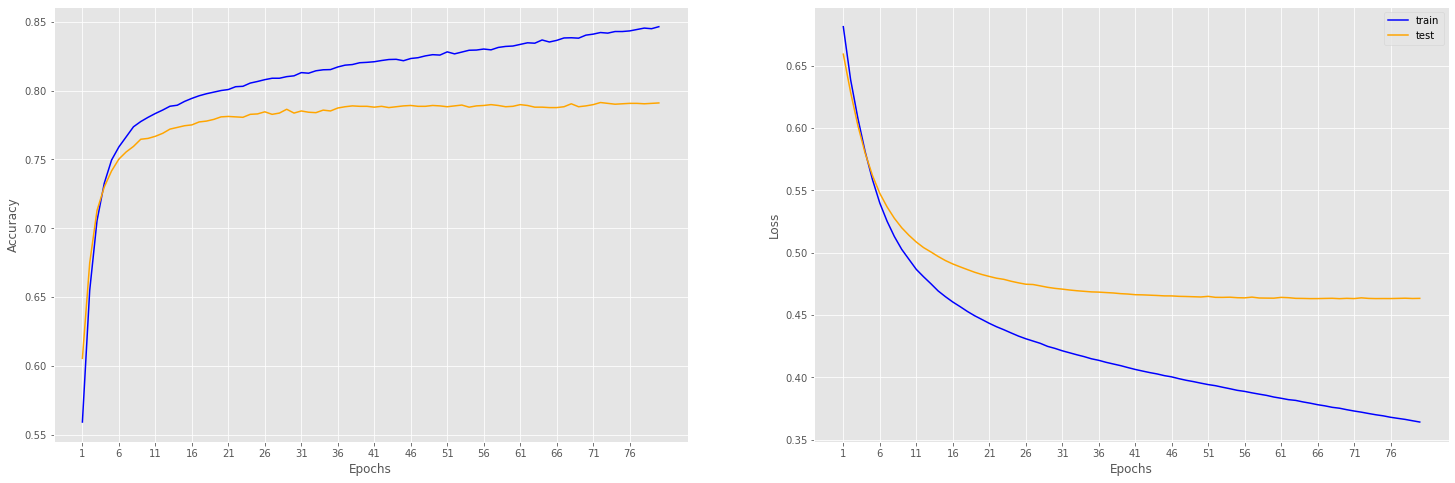

In [46]:
epochs = range(1, EPOCHS+1)
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

axs[0].plot(epochs, history.history['acc'], color='blue', label='train')
axs[0].plot(epochs, history.history['val_acc'], color='orange', label='test')
axs[0].set_xticks(range(1, EPOCHS+1, 5))
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')

axs[1].plot(epochs, history.history['loss'], color='blue', label='train')
axs[1].plot(epochs, history.history['val_loss'], color='orange', label='test')
axs[1].set_xticks(range(1, EPOCHS+1, 5))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
plt.legend()

* The best score reaches 0.79 of accuracy

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x294aa0b2be0>)

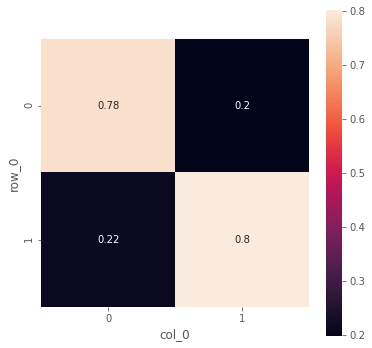

In [47]:
y_pred = model.predict(X_test).reshape(1, -1)[0]
y_pred = np.around(y_pred).astype(int)

plot_confusion_matrix(y_test, y_pred)

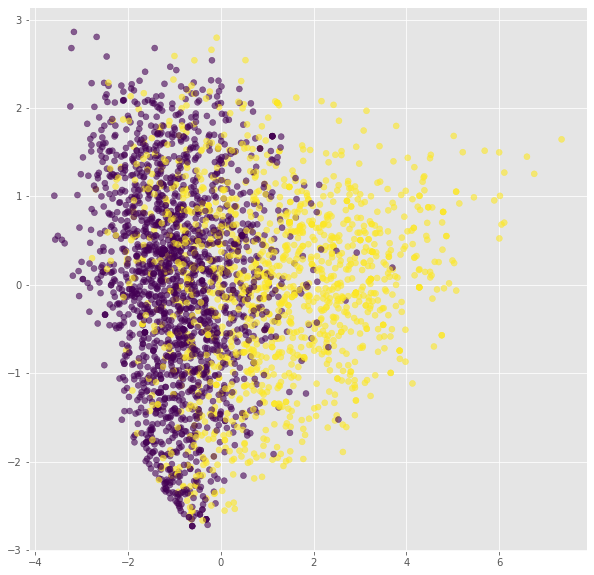

In [48]:
from sklearn.decomposition import PCA

embed = lambda x: e(d(c(b(a(x)))))
embedded_text = embed(X_test)

twodim = PCA(2).fit_transform(embedded_text)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(twodim[:,0], twodim[:,1], c=y_test, alpha=.6)

## Model's mistakes

In [49]:
df_test['pred'] = y_pred
model_errors = df_test[df_test['pred'] != df_test['target']]
model_errors

,id,keyword,text,target,source,clean_text,pred
6855,46,ablaze,Birmingham Wholesale Market is ablaze BBC News...,1,test,birmingham wholesale market is ablaze bbc news...,0
6861,70,ablaze,Burning Man Ablaze! by Turban Diva http://t.co...,0,test,burning man ablaze by turban diva via,1
6872,106,accident,#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Came...,0,test,car recorder zeroedge dual lens car camera ve...,1
6873,108,accident,Coincidence Or #Curse? Still #Unresolved Secre...,0,test,coincidence or curse still unresolved secrets ...,1
6876,116,accident,For Legal and Medical Referral Service @1800_I...,0,test,for legal and medical referral service call us...,1
...,...,...,...,...,...,...,...
10084,10797,wrecked,@Nathan26_RFC thought you said Saturday night ...,0,test,thought you said saturday night there and nea...,1
10086,10804,wrecked,@yakubOObs think he deactivated because his no...,1,test,think he deactivated because his notification...,0
10087,10806,wrecked,RT CNBC '3 words from Disney CEO Bob Iger wrec...,1,test,rt cnbc words from disney ceo bob iger wrecked...,0
10098,10861,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0,test,earthquake safety los angeles safety fasteners...,1


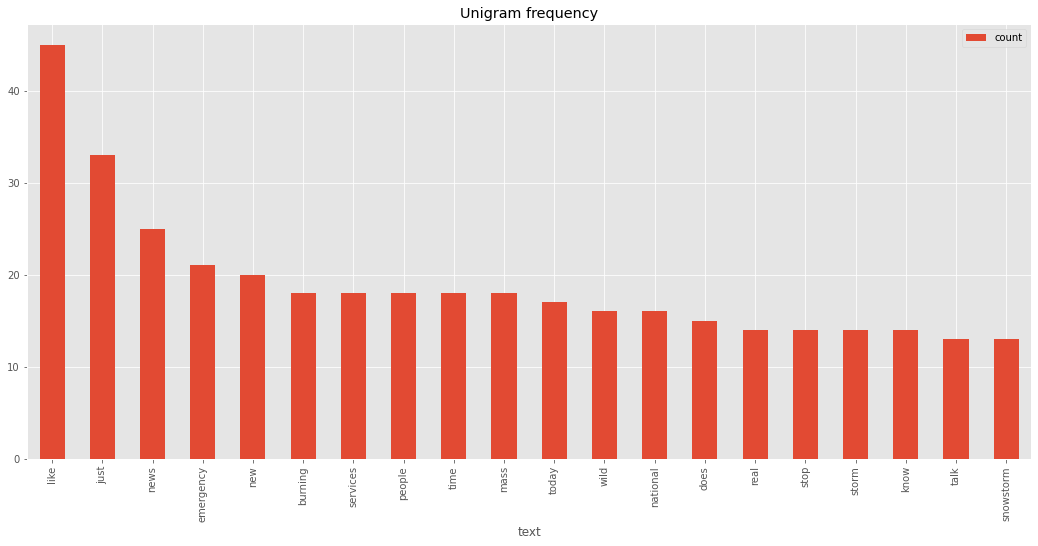

In [50]:
top_unigrams = get_top_grams(model_errors['clean_text'], 20)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_unigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Unigram frequency')

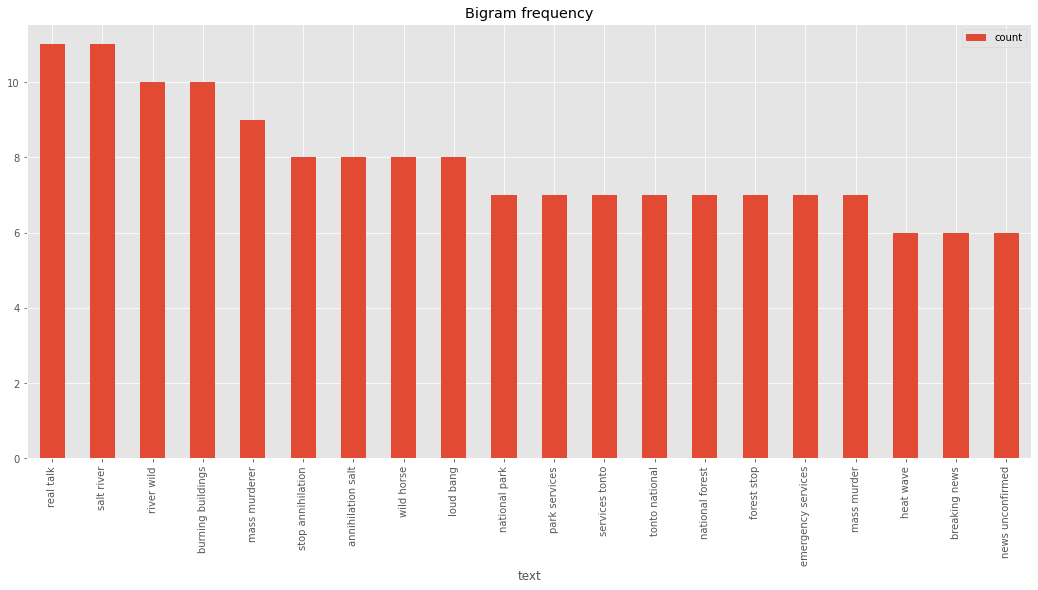

In [51]:
top_bigrams = get_top_grams(model_errors['clean_text'], 20, gram=2)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_bigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Bigram frequency')

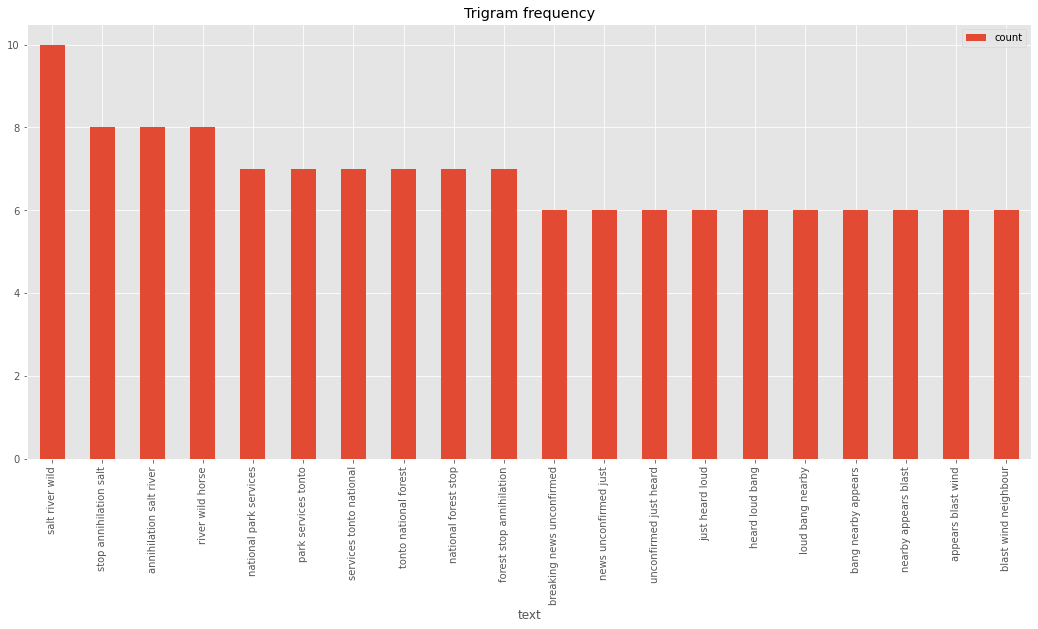

In [52]:
top_bigrams = get_top_grams(model_errors['clean_text'], 20, gram=3)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))

df1 = pd.DataFrame(top_bigrams, columns = ['text' , 'count'])
df1['count'] = df1['count'].astype(float)
df1.plot(x='text', y='count', kind='bar', ax=ax, title='Trigram frequency')